In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.integrate import odeint
import pickle as pkl
from utils_plot import get_mean_std_hbec
from utils import new_preprocessing_rna_seq_data

from functions import clock_model
import warnings
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

def set_matplotlib_params():

    """Set matplotlib params."""

    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams.update(
        {
            "font.size": 22,
            "lines.linewidth": 2,
            "axes.labelsize": 24,  # fontsize for x and y labels
            "axes.titlesize": 24,
            "xtick.labelsize": 20,
            "ytick.labelsize": 20,
            "legend.fontsize": 20,
            "axes.linewidth": 2,
            "text.usetex": False,  # use LaTeX to write all text
            "axes.spines.right": False,
            "axes.spines.top": False,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.grid": False,
        }
    )

set_matplotlib_params()

In [28]:
# IMPORTATION ##################################################################################
error = 2.032966400368863
error = 0.8162215513450485
params = np.loadtxt(f'results/example_new_cmaes_result_{error}.txt')[0]
tspan = np.linspace(0, 1200, 12001)
y0 = np.loadtxt('data/y0.txt')

with open('data/Jeu_9/data/data_dict_concentration.dat', 'rb') as fun:
    data_hbec_rna = pkl.load(fun)
    
with open("data/dict_comparison", "rb") as f:
    data_hbec_prot = pkl.load(f)

# SOLUTION OF THE ODE ##########################################################################
Y = odeint(clock_model, y0, tspan, args=(params,), rtol=10**(-12), atol=10**(-12)) 
Y_plot = Y[-601:]*10**9#*10**12

In [29]:
filename = "data/Jeu_9/data/data_dict_concentration_cc.dat"
with open(filename, "rb") as f:
    rna_seq_data = pkl.load(f)
    
# Data formating
rna_seq_list, rna_seq_cts = new_preprocessing_rna_seq_data(rna_seq_data)

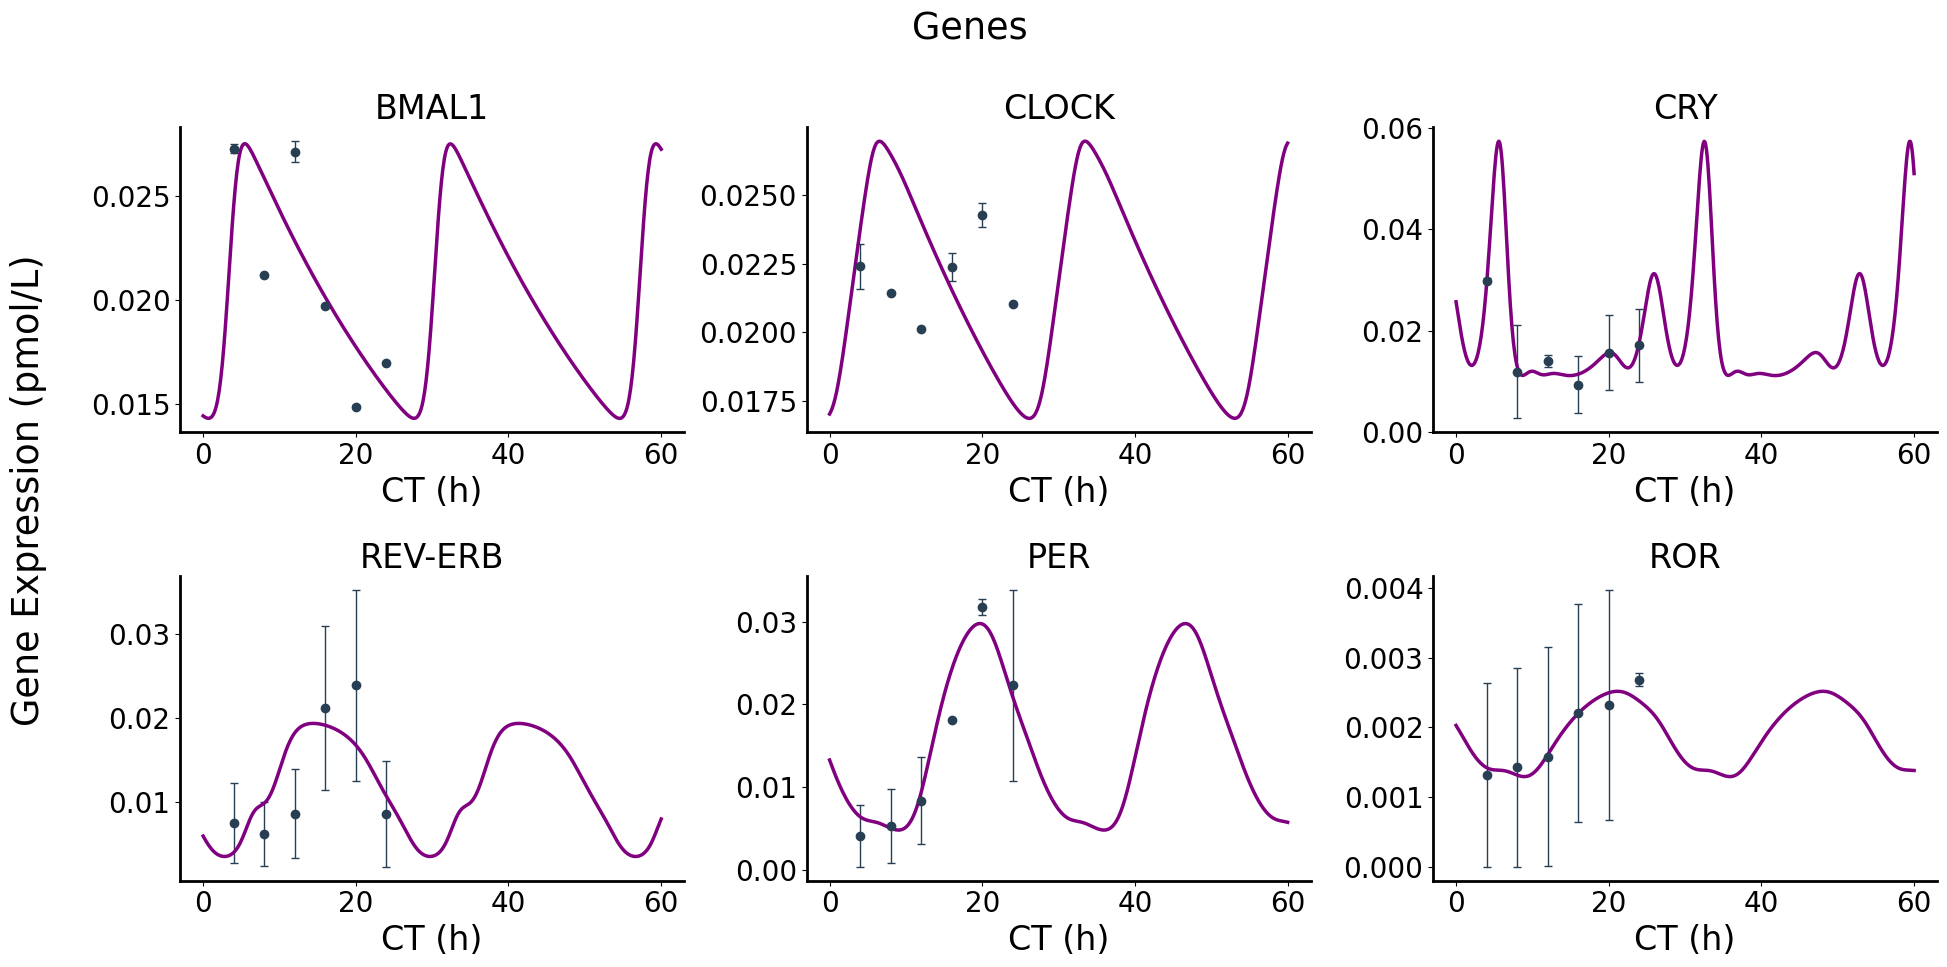

In [30]:
# PLOT RNA-SEQUENCING ##########################################################################

names_genes = ["BMAL1", "CLOCK", "CRY", "REV-ERB", "PER", "ROR"]
gene_coords = [8, 17, 5, 6, 4, 7]
t_plot = np.linspace(0, 60, 601)

count, count2 = 0, 0
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, j in enumerate(gene_coords):
    ax = axes.flat[i]
    #mean_vector, std_vector = get_mean_std_hbec(names_genes[i], data_hbec_rna)
    mean_vector, std_vector = [np.mean(l) for l in rna_seq_list[i]], [np.std(l) for l in rna_seq_list[i]]
    ax.errorbar(data_hbec_rna["CTs"], mean_vector, std_vector, fmt='o', linewidth=1, capsize=3, mfc= "#283F53", mec = "#283F53", ecolor ="#283F53")
    ax.plot(t_plot, Y_plot[:, j], color='purple', label='sw480 clock model', linewidth=2.5)
    ax.set_title(names_genes[i])
    ax.set_xlabel('CT (h)')
fig.supylabel('Gene Expression (pmol/L)')
fig.suptitle('Genes')
fig.tight_layout()
#fig.savefig('genes_2.05.pdf', transparent=True, bbox_inches='tight')
plt.show()


In [31]:
Y_plot = Y[-601:]*10**9

# Weights vector initialisation 
vc, vn = 0.72, 0.28
w = np.zeros(y0.shape[0])
w[0:4] = vn
w[4:9] = 1
w[9:] = vc
w[-1] = 1

data_Y_plot = {}
# BMAL1 = CLOCK/BMAL_N + BMAL_C + CLOCK/BMAL_C
data_Y_plot["BMAL1"] = w[0]*Y_plot[:,0] + w[15]*Y_plot[:,15] + w[16]*Y_plot[:,16]

# CRY = PER/CRY_N + CRY_C + PER/CRY_C
data_Y_plot["CRY"] = w[1]*Y_plot[:,1] + w[9]*Y_plot[:,9] + w[11]*Y_plot[:,11] 

# REV-ERB = REV-ERB_N + REV-ERB_C
data_Y_plot["REV-ERB"] = w[2]*Y_plot[:,2] + w[13]*Y_plot[:,13] 

# BMAL1_ N = CLOCK/BMAL_N
data_Y_plot["BMAL1_N"] = Y_plot[:,0]

# CRY_N = PER/CRY_N
data_Y_plot["CRY_N"] = Y_plot[:,1]

# CRY_C = CRY_C + PER/CRY_C
data_Y_plot["CRY_C"] =  Y_plot[:,9] + Y_plot[:,11] 

# PER_N = PER/CRY_N
data_Y_plot["PER_N"] = Y_plot[:,1]

# PER =  PER/CRY_N + PER_C + PER/CRY_C
data_Y_plot["PER"] = w[1]*Y_plot[:,1] + w[10]*Y_plot[:,10] + w[11]*Y_plot[:,11] 

# CLOCK = CLOCK/BMAL_N + CLOCK_C + CLOCK/BMAL_C
data_Y_plot["CLOCK"] = w[0]*Y_plot[:,0] + w[12]*Y_plot[:,12] + w[16]*Y_plot[:,16]

# ROR = ROR_N + ROR_C 
data_Y_plot["ROR"] = w[3]*Y_plot[:,3] + w[14]*Y_plot[:,14]


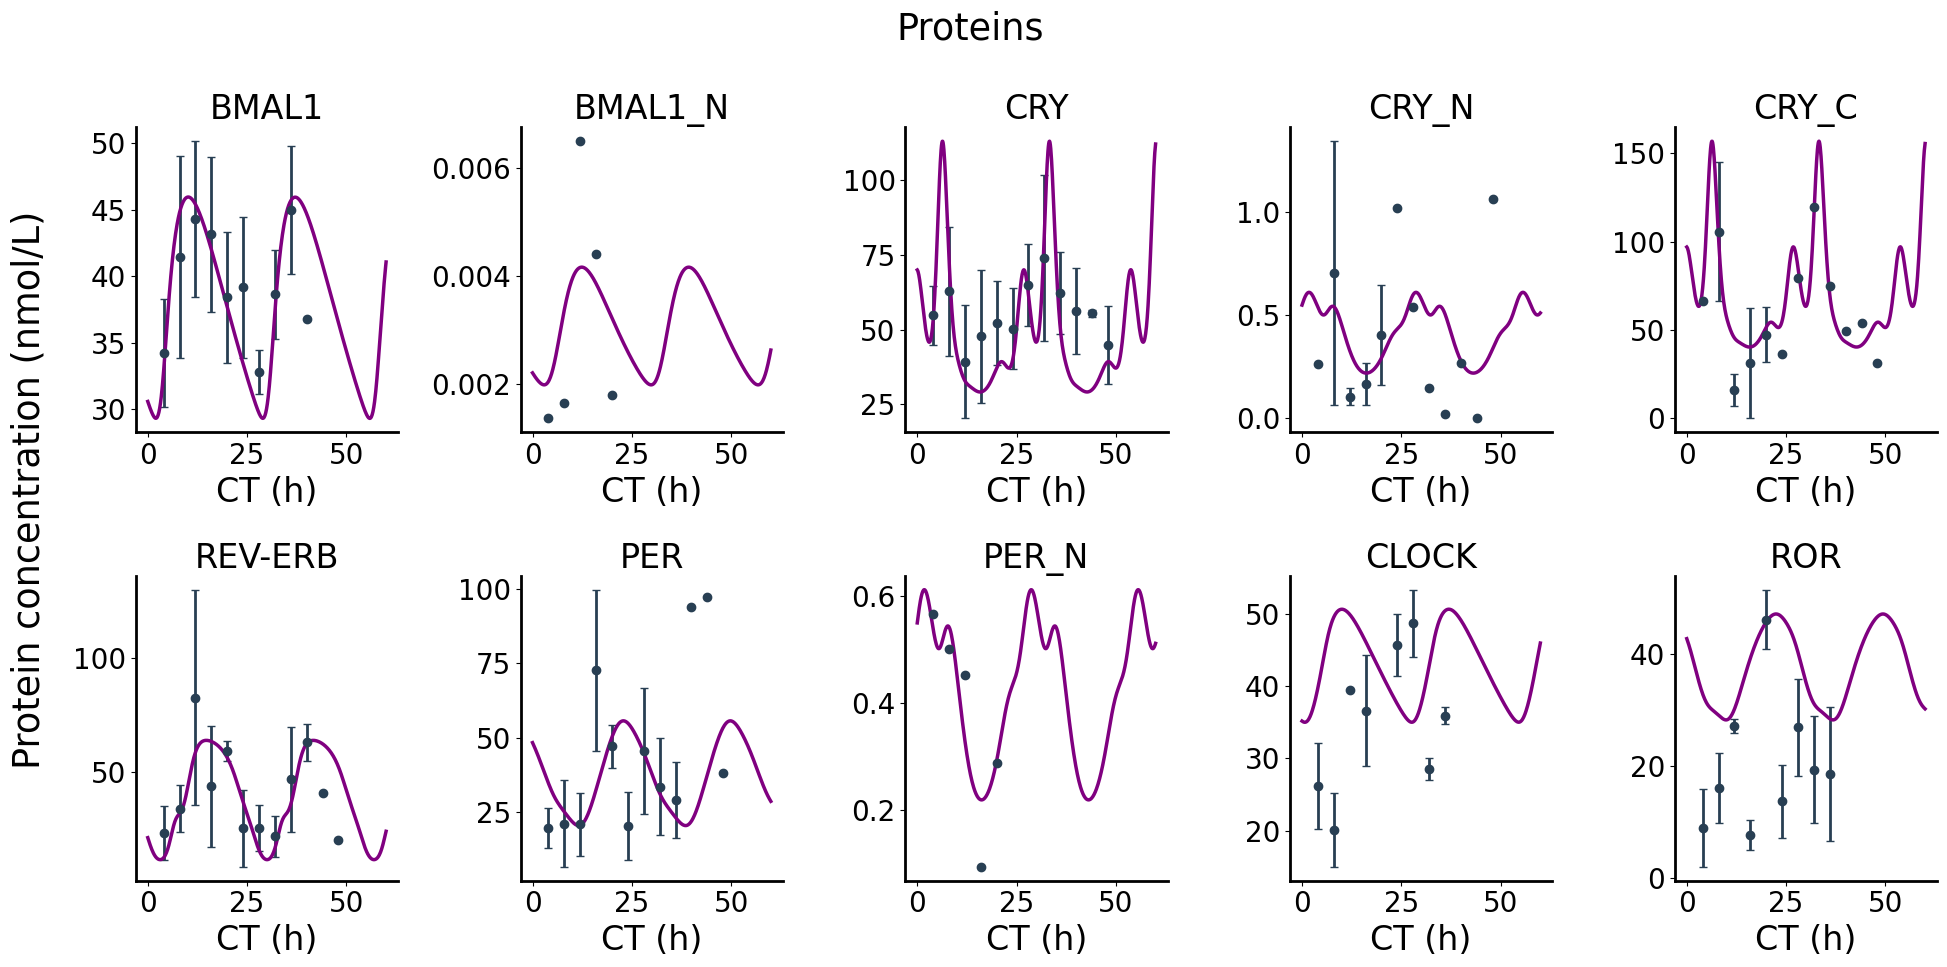

In [32]:
# PLOT PROTEINS #############################################################################

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for (i, ax), name_prot in zip(enumerate(axes.flat), data_hbec_prot.keys()):
    cts_lengths = [len(jeu_data['cts']) if isinstance(jeu_data, dict) and 'cts' in jeu_data else 0 for jeu_data in data_hbec_prot[name_prot].values()]
    longest_cts_index = np.argmax(cts_lengths)
    longest_cts_list = data_hbec_prot[name_prot][list(data_hbec_prot[name_prot].keys())[longest_cts_index]]['cts']

    len_cts_list = len(longest_cts_list)
    
    ax.errorbar(longest_cts_list,  data_hbec_prot[name_prot]["mean"], yerr= data_hbec_prot[name_prot]["std"], linestyle='None', marker='o', color ="#283F53", capsize=3, capthick=1)
    ax.plot(t_plot, data_Y_plot[name_prot], color='purple', label='sw480 clock model', linewidth=2.5)
    ax.set_xlabel('CT (h)')
    ax.set_title(str(name_prot))
fig.supylabel('Protein concentration (nmol/L)')
fig.suptitle('Proteins')
fig.tight_layout()
#fig.savefig('prot_2.05.pdf', transparent=True, bbox_inches='tight')
plt.show()

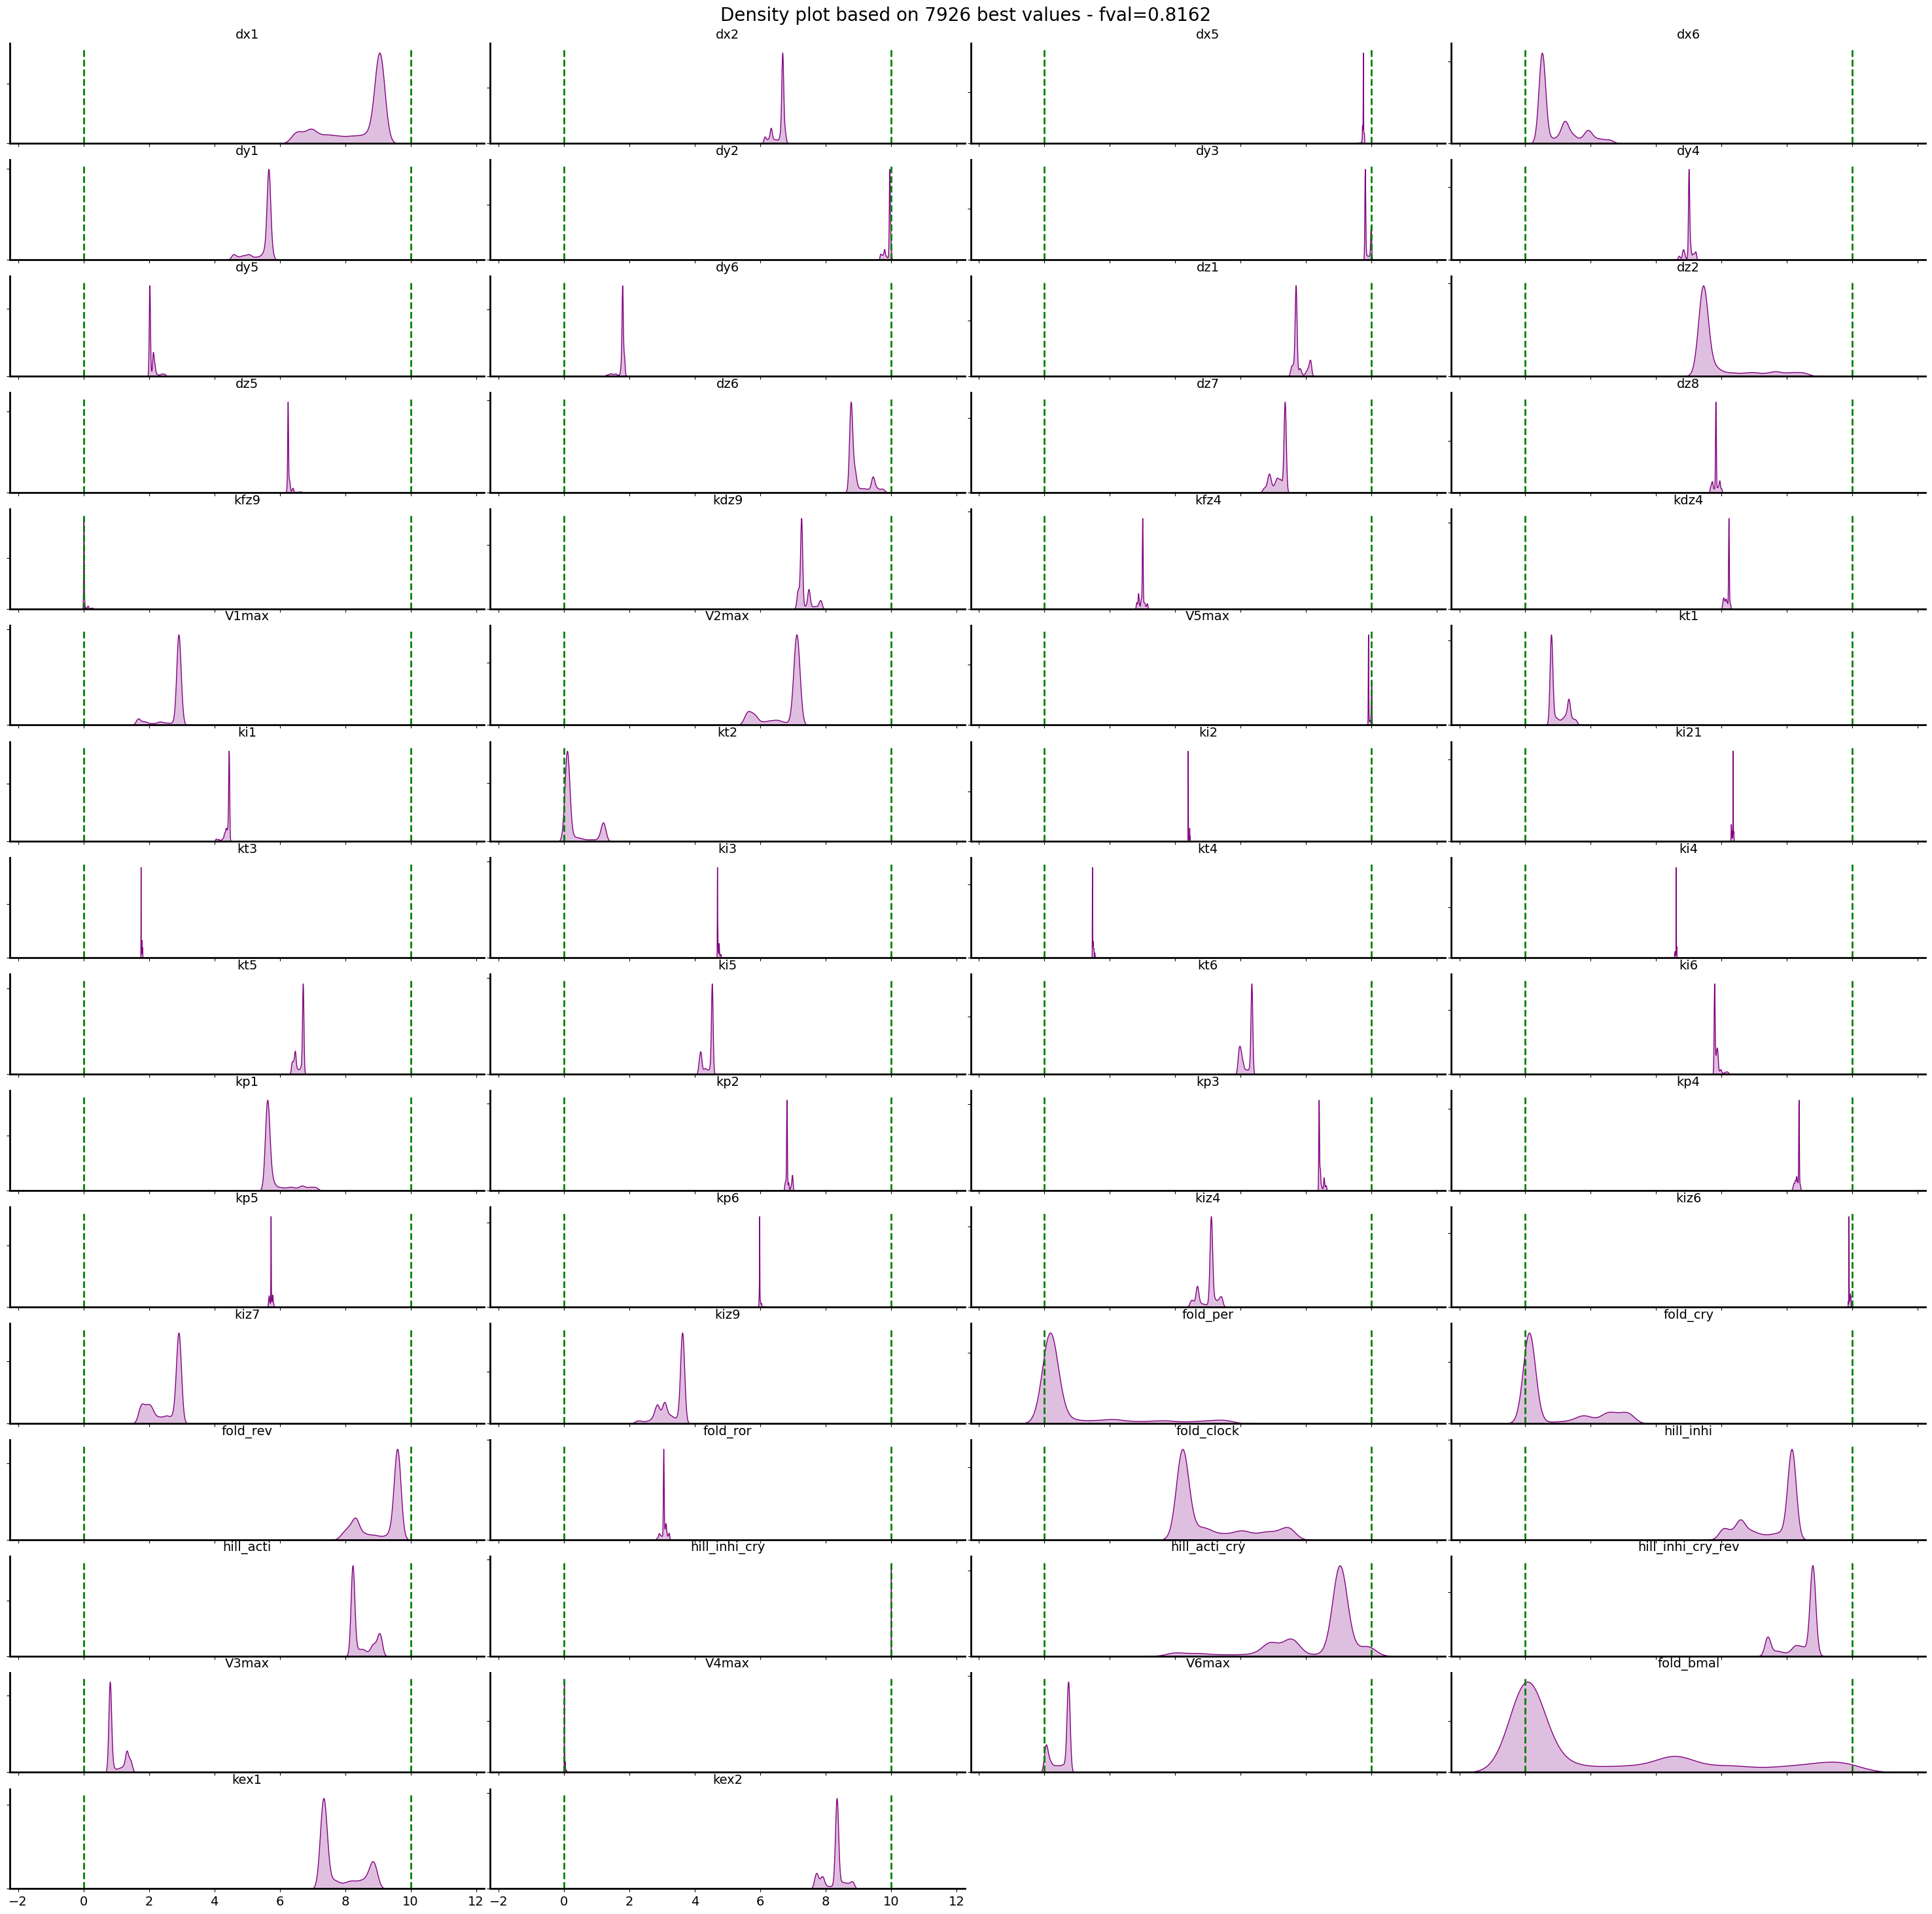

In [33]:
def get_params_from_cmaes(datfile):

    """
    Parse cma-es results .dat file to show statistics on
    parameter sets.
    """
    with open(datfile, 'r') as f:
        output = f.read()
    idx, lines, evals, time_params, time_fitness = [], [], [], [], []
    for i in range(len(output)):
        if output[i:i + 1] == "\n":
            idx.append(i)
    for i in range(len(idx) - 1):
        lines.append(output[idx[i]:idx[i + 1]])
    for line in lines:
        line_split = line.split()
        evals.append(int(line_split[1]))
        time_fitness.append(float(line_split[4]))
        time_params.append(np.array(line_split[5:]).astype(float))
    return evals, time_fitness, time_params


def plot_params_distrib(filename, list_params, save=False, scale='linear', sharex=True):

    """
    Density plot for the parameters based on 10% best fitness values.
    Plotted values are within the scaled parameter space [0, 10].
    """

    evals, fitness_dist, params_dist = get_params_from_cmaes(filename)
    fitness_dist = np.array(fitness_dist)
    best = np.where(fitness_dist / np.min(fitness_dist) < 1.01)[0]
    fval = np.round(np.min(fitness_dist), 4)

    fig, axes = plt.subplots(16, 4, figsize=(30, 30), sharex=sharex)
    fig.suptitle(f'Density plot based on {len(best)} best values - fval={fval}',
                 fontsize=20)
    for i, ax in zip(range(len(list_params)), axes.flat):
        sns.kdeplot([params_dist[j][i] for j in best], fill=True,
                    color='purple', ax=ax)
        ax.set_title(list_params[i], fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.set_ylabel('')
        ax.set_xticklabels([''])
        ax.set_yticklabels([''])
        ax.set_xscale(scale)
        ymin, ymax = ax.get_ylim()
        ax.vlines(0, ymin, ymax, color='green', linestyle='--')
        ax.vlines(10, ymin, ymax, color='green', linestyle='--')
    [fig.delaxes(axes[-1, i]) for i in [-1, -2]]
    fig.tight_layout(w_pad=0, h_pad=-.1)
    if save:
        plt.savefig(f'params_dist_error{fval}.pdf', transparent=True)
    plt.show()

list_params = ['dx{}'.format(i) for i in [1, 2, 5, 6]] \
            + ['dy{}'.format(i) for i in range(1, 7)] \
            + ['dz{}'.format(i) for i in [1, 2, 5, 6, 7, 8]] \
            + ['kfz9', 'kdz9', 'kfz4', 'kdz4'] \
            + ['V{}max'.format(i) for i in [1, 2, 5]] \
            + ['kt1', 'ki1', 'kt2', 'ki2', 'ki21', 'kt3', 'ki3', 'kt4', 'ki4', 'kt5', 'ki5', 'kt6', 'ki6'] \
            + ['kp{}'.format(i) for i in range(1, 7)] \
            + ['kiz{}'.format(i) for i in [4, 6, 7, 9]] \
            + ['fold_per', 'fold_cry', 'fold_rev', 'fold_ror', 'fold_clock'] \
            + ['hill_inhi', 'hill_acti', 'hill_inhi_cry', 'hill_acti_cry', 'hill_inhi_cry_rev'] \
            + ['V3max', 'V4max', 'V6max', 'fold_bmal', 'kex1', 'kex2']

plot_params_distrib(f'outcmaes/params_dist_{error}.dat', list_params)

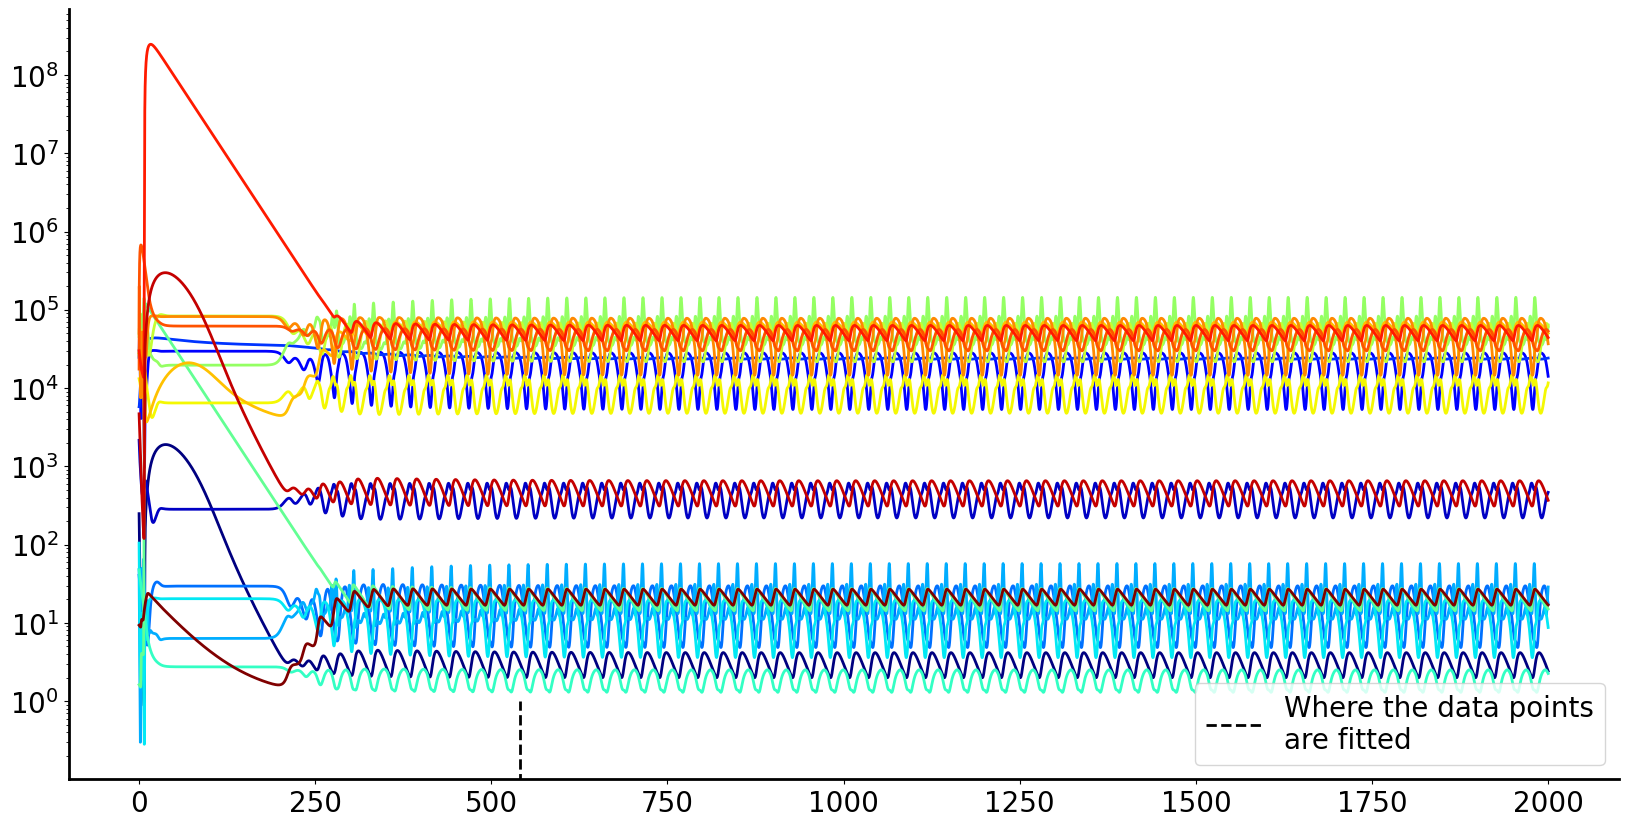

In [34]:
t2000 = np.linspace(0, 2000, 20001)
Y2000 = odeint(clock_model, y0, t2000, args=(params,), rtol=10**(-12), atol=10**(-12))
Y2000 *= 10**12
list_species = ['CLOCK/BMAL_N', 'PER/CRY_N', 'REV-ERB_N', 'ROR_N'] + ['Per', 'Cry', 'Rev-erb', 'Ror', 'Bmal'] + ['CRY_C', 'PER_C', 'PER/CRY_C', 'CLOCK_C', 'REV-ERB_C', 'ROR_C', 'BMAL_C', 'CLOCK/BMAL_C'] + ['Clock']

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(list_species)))

plt.figure(figsize=(20, 10))
for i in range(Y.shape[1]):
    plt.plot(t2000, Y2000[:, i], color=colors[i])
plt.vlines(540, 0,1, linestyle='--', color='black',
           label='Where the data points\nare fitted')
plt.yscale('log')
plt.legend(fontsize=20, loc='lower right')
plt.show()

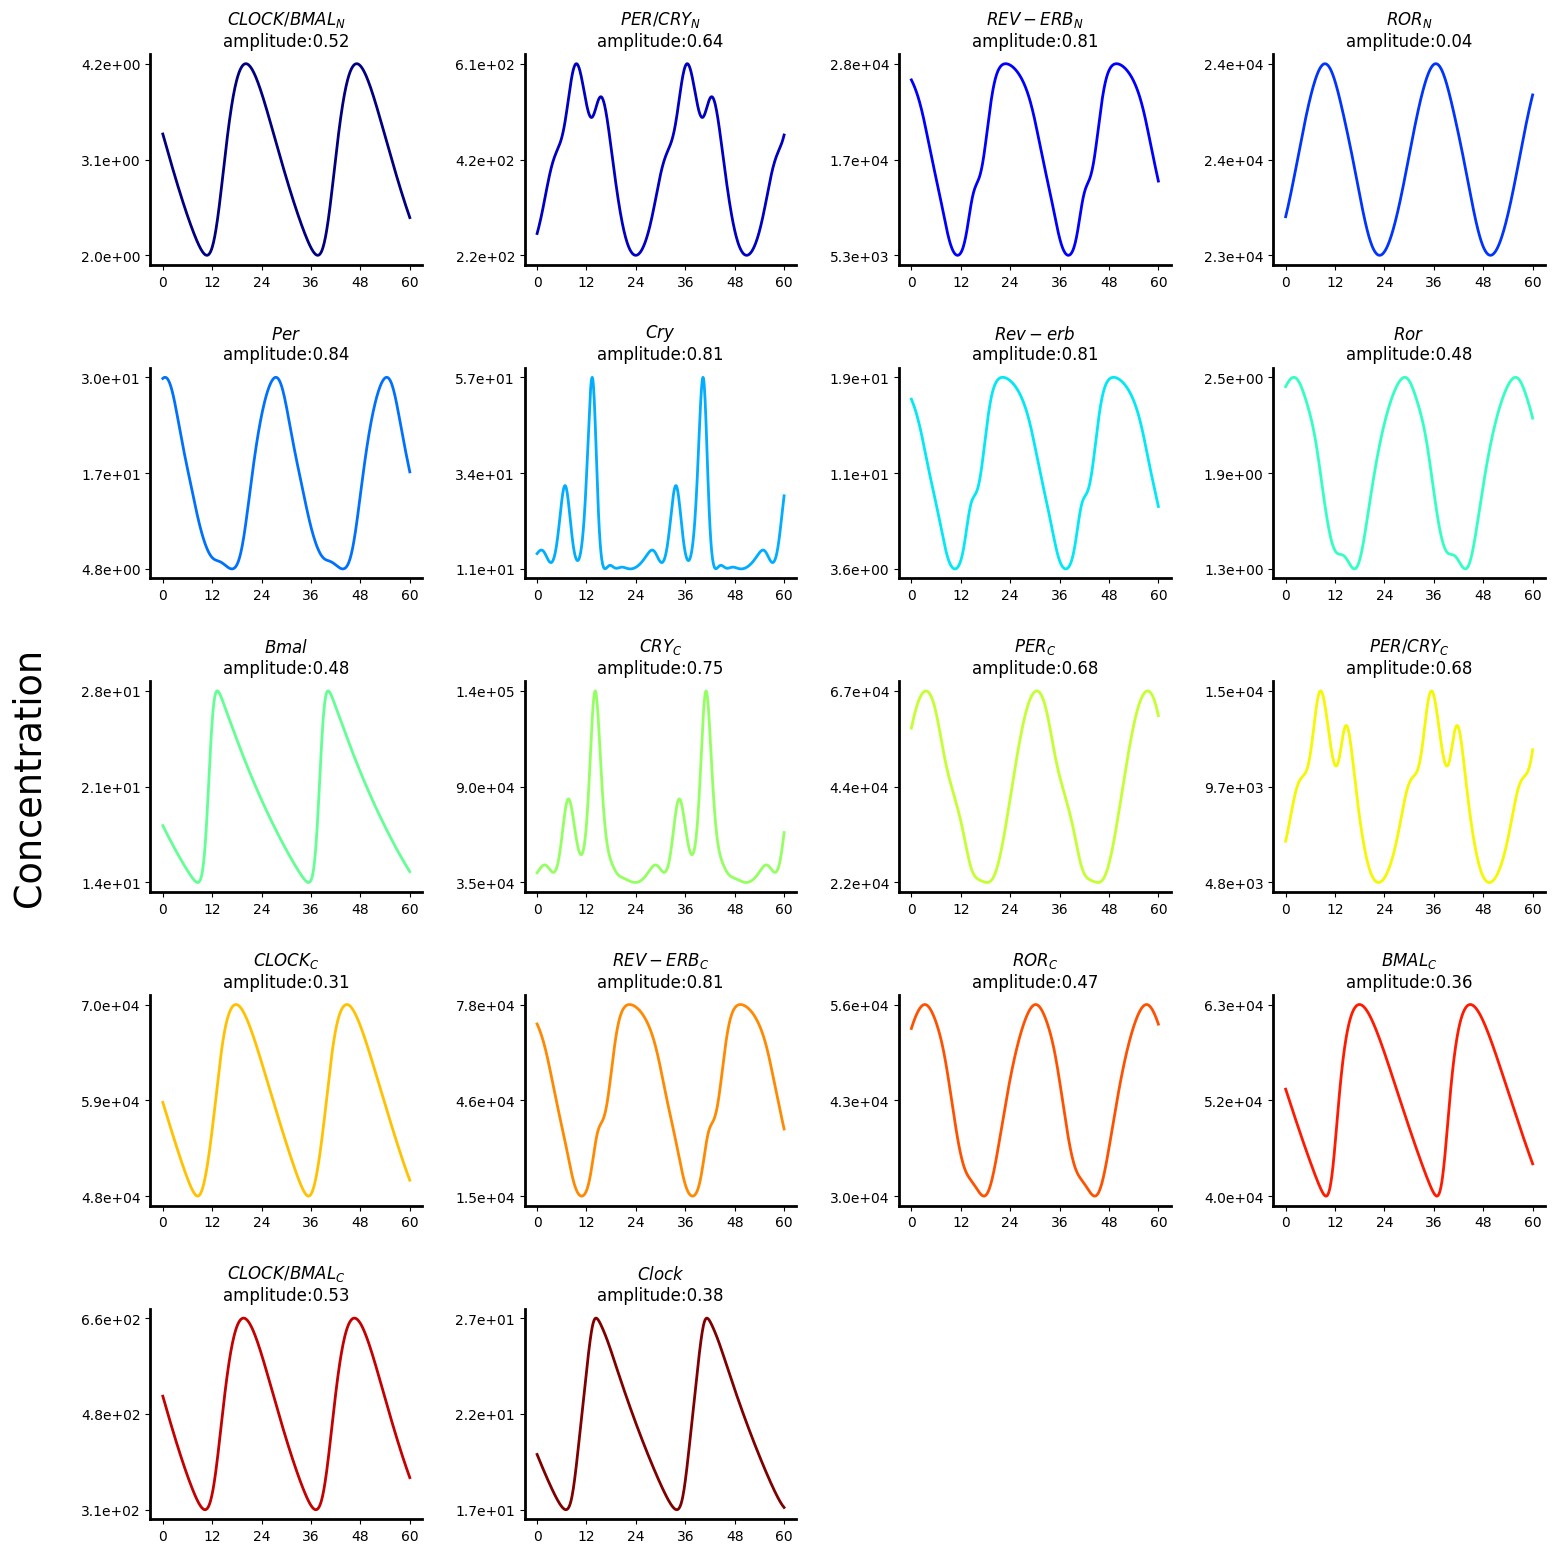

In [35]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

fig, axes = plt.subplots(5, 4, figsize=(16, 16))
fig.subplots_adjust(wspace=.3, top=.94)
tplot = 601
fig.supylabel('Concentration')
for i, ax in zip(range(len(list_species)), axes.flat):
    y = Y2000[-tplot:, i]
    amp = (y.max() - y.min()) / y.max()
    ax.plot(t2000[:tplot], y,
            color=colors[i])
    ax.set_title(f'${list_species[i]}$\namplitude:{amp:.2f}', fontsize=12)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    ax.set_yticks(np.linspace(np.min(y), np.max(y), 3))
    ax.set_xticks(np.arange(0, 61, 12))
fig.delaxes(axes[4, 3])
fig.delaxes(axes[4, 2])
fig.tight_layout()
plt.show()